# Stokes Flow (Lid Driven Cavity Problem)

As per the assumptions mentioned in the problem statement,

 * solution to be found at steady state
 * Reynolds number considered to be zero (too small), depicting Stokes flow

and by mathematical operations as shown in the problem statement, we get the **Simplified Vorticity Transport Equation for Stokes Flow** as follows: 

$$
\begin{equation}
\nabla ^2 \omega = 0
\end{equation}
$$

*This is in Laplace form and can be solved by iterative methods.* 

In order to relate the vorticity to the streamfunction, we have the following equation:

$$
\begin{equation}
\nabla^2 \psi = -\omega
\end{equation}
$$

*This is in Poissons form and can be solved by iterative methods.* 

Both the equations are coupled by $\omega$ which acts as the source term in the Poisson equation for $\psi$. 

The domain of the problem and the boundary conditions (given in the terms of $\psi$) are depicted as follows: 

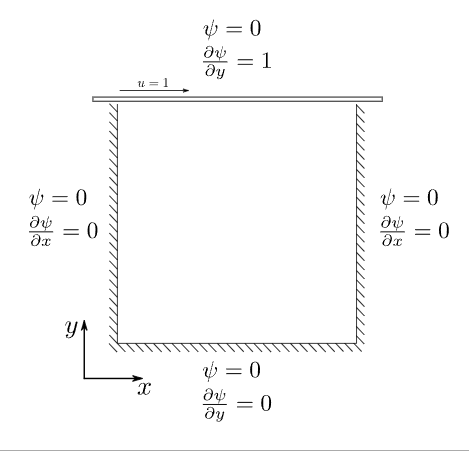

In order to solve this problem, I referred the following reference: 

* Greenspan, D. (1974). Discrete numerical methods in physics and engineering (Vol. 312). New York: Academic Press.

I will directly mention images from this book for the explanation of the solution

In [162]:
import numpy
from matplotlib import pyplot
import time
from matplotlib import cm
%matplotlib inline
import numba
from numba import jit
import math

In [163]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [164]:
def l1_norm(u, u_ref):
    """
    Computes and returns the L1-norm of the difference
    between a solution u and a reference solution u_ref.

    Parameters
    ----------
    u : numpy.ndarray
        The solution as an array of floats.
    u_ref : numpy.ndarray
        The reference solution as an array of floats.

    Returns
    -------
    diff : float
        The L2-norm of the difference.
    """
    diff = numpy.sum(numpy.abs(u - u_ref))
    return diff

In [165]:
#setting parameters
nx, ny = 41, 41  # number of points in each direction
L = 1.0
dx = L/(nx -1)
dy = L/(ny -1)

x = numpy.linspace(0.0, L, num = nx)
y = numpy.linspace(0.0, L, num = ny)

#initial guesses
psi0 = numpy.zeros((ny, nx))
omega0 = numpy.zeros((ny, nx))

The key idea to solve the coupled equations is mentioned in the reference and is quite easy to understand: 

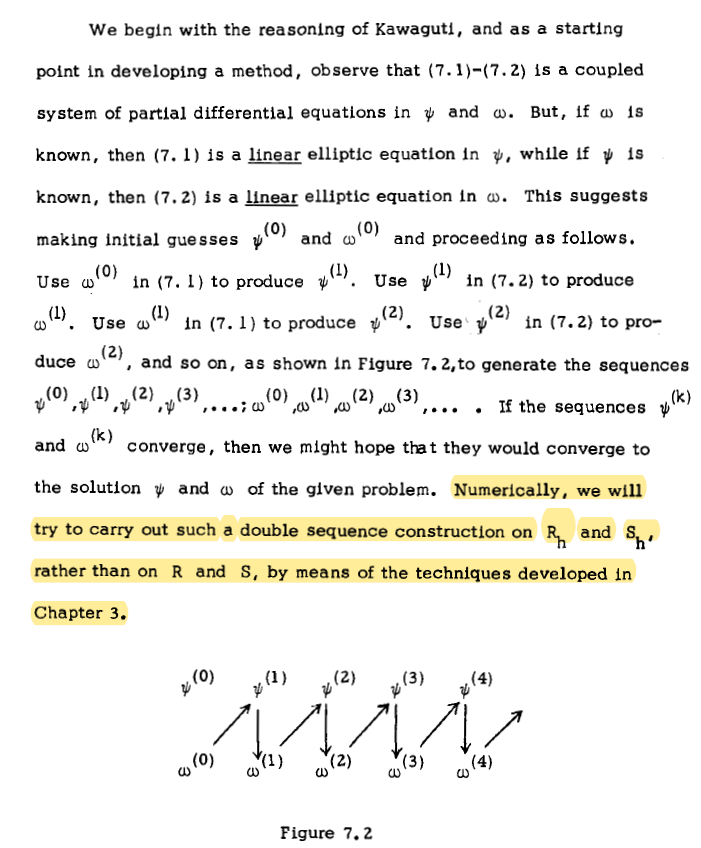

The author uses the following nomeclature to indicate the four neighbouring points i.e. $(i+1, j), (i, j+1), (i-1, j), (i, j-1)$. 

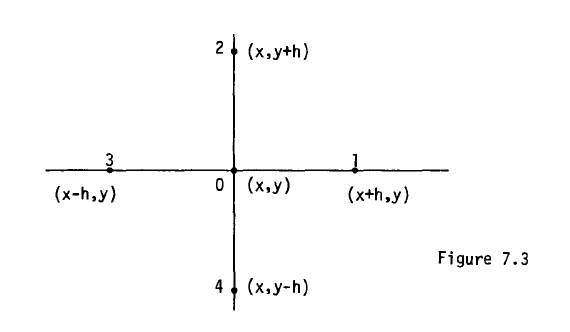

Here I mention the steps summarised as an algorithm, as given in the reference, but I encourage anyone referring to this solution to go through the explanation and derivation of the scheme. 

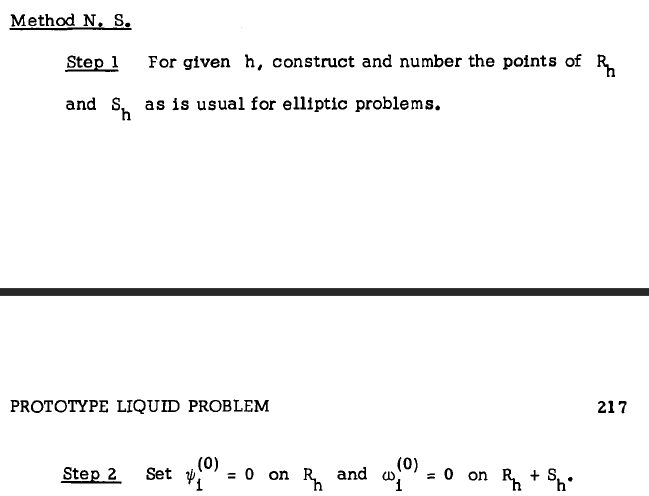
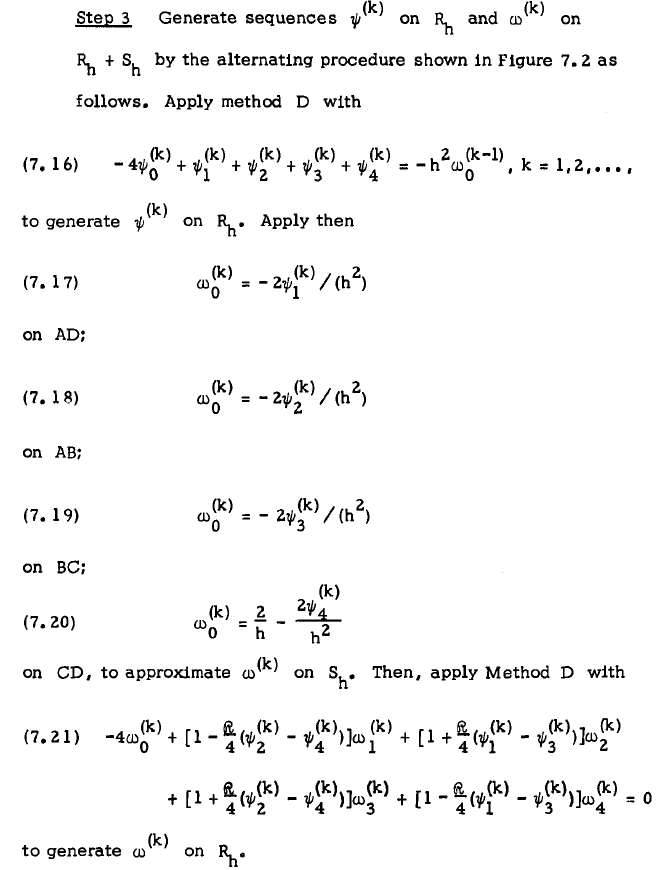
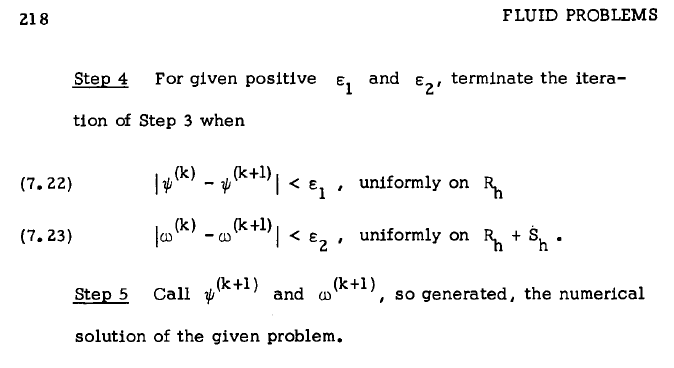

----

It should be noticed that the method shown above considers a non-zero Reynolds number. However, if the Reynolds number is assumed zero, things can only get easier. 

Also, please note that the method diverges for R > 250 and dx = 1 / 40. 

The author has provided further modifications to the method, but those are useful only when the Reynolds number is considered greater than zero.

In the function below, I have directly used the method mentioned in the reference with a slight change in the signs of the boundary conditions to match with the situation in the problem statement. 

In [166]:
@jit(nopython=True)
def cavity_gauss_siedel1(psi0, omega0, dx, maxiter=20000, rtol = 1e-6):
    
    nx, ny = psi0.shape
    psi = psi0.copy()
    omega = omega0.copy()
    diff_psi = 1.0
    diff_omega = rtol + 1.0
    ite = 0
    conv_psi = []
    conv_omega = []
    
    while diff_omega>rtol or diff_psi>rtol and ite<maxiter:
        
        #Setting up the iterations
        psi_n = psi.copy()
        
        #iterating for psi
        for j in range(1, ny-1):
            for i in range(1, ny-1):
                psi[j, i] = 0.25*(psi[j-1, i] + psi[j+1, i] + psi[j, i-1] + psi[j, i+1] + omega[j, i]*(dx**2))
        
        diff_psi = numpy.sum(numpy.abs(psi[1:-1, 1:-1] - psi_n[1:-1, 1:-1]))
        
        #iterating for omega
        omega_n = omega.copy()
        
        for j in range(1, ny-1):
            for i in range(1, ny-1):
                omega[j, i] = 0.25*(omega[j-1, i] + omega[j+1, i] + omega[j, i-1] + omega[j, i+1])
        
        #Applying boundary conditions (acc to book ref)
        #left bc
        for j in range(1, ny-1):
            omega[j, 0] = (-2/(dx**2))*psi[j, 1]
            
        #bottom bc
        for i in range(1, nx-1):
            omega[0, i] = (-2/(dx**2))*psi[1, i]
            
        #right bc
        for j in range(1, ny-1):
            omega[j, -1] = (-2/(dx**2))*psi[j, -2]
            
        #top bc
        for i in range(1, nx-1):
            omega[-1, i] = -2/dx - (2/(dx**2))*psi[-2, i]
        
        diff_omega = numpy.sum(numpy.abs(omega - omega_n))
        
        #recording l1_norms at each iteration
        conv_psi.append(diff_psi)
        conv_omega.append(diff_omega)
        
        ite = ite + 1
        
    return psi, omega, ite, conv_psi, conv_omega

In [167]:
tic = time.time()
psi1, omega1, ites1, conv_psi1, conv_omega1 = cavity_gauss_siedel1(psi0, omega0, dx, maxiter=20000, rtol = 1e-6)
toc = time.time()

print('{} iterations '.format(ites1) + 'to reach a relative difference of {} for psi and {} for omega'.format(conv_psi1[-1], conv_omega1[-1]))
print('time required {}'.format(toc - tic))

2127 iterations to reach a relative difference of 7.407527702829837e-09 for psi and 9.95646749581136e-07 for omega
time required 1.9152531623840332


In [168]:
ll1, mm1 = numpy.max(psi), numpy.min(psi)
print(mm1, ll1)

-0.0998195091945568 4.001864530926678e-06


In [169]:
numpy.max(omega), numpy.min(omega)

(22.125412766156078, -57.874587233996266)

In [170]:
numpy.round(psi[32,::8], 4)

array([ 0.    , -0.0576, -0.0944, -0.0944, -0.0576,  0.    ])

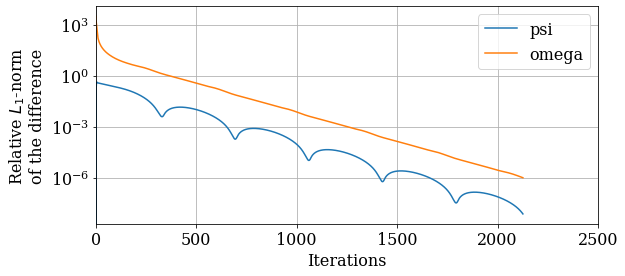

In [171]:
# Plot the convergence history.
pyplot.figure(figsize=(9.0, 4.0))
pyplot.xlabel('Iterations')
pyplot.ylabel('Relative $L_1$-norm\nof the difference')
pyplot.grid()
pyplot.semilogy(conv_psi[:], label='psi')
pyplot.semilogy(conv_omega[:], label='omega')
pyplot.legend()
pyplot.xlim(0, 2500);

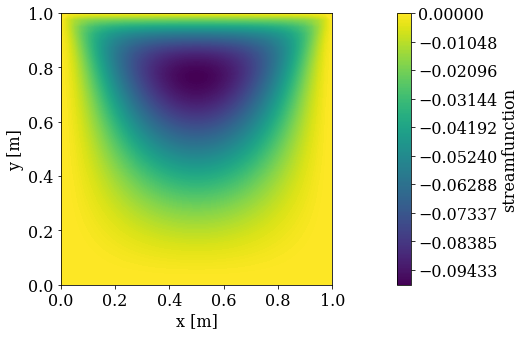

In [172]:
# Plot the filled contour of streamfunction
pyplot.figure(figsize=(8.0, 5.0))
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]')
levels = numpy.linspace(mm1, ll1, num=201)
contf = pyplot.contourf(x, y, psi, levels=levels)
cbar = pyplot.colorbar(contf)
cbar.set_label('streamfunction')
pyplot.axis('scaled');

In the previous function, the boundary conditions mentioned in the reference were not as per those mentioned in the problem statement. The reference uses first order boundary conditions, while the problem statement considers second order boundary conditions. 

In the function below, I have incorporated second order boundary conditions as expected in the problem statement. (Take care of the +ve/-ve signs while considering the boundary conditions, or else the solution diverges)

The following reference also gives a quick derivation and numerical scheme for solving the lid-driven cavity problem in 2D. 

* A. Salih, "Streamfunction-Vorticity Formulation", Department of Aerospace Engineering, Indian Institute of Space Science and Technology, Thiruvananthapuram



In [173]:
@jit(nopython=True)
def cavity_gauss_siedel2(psi0, omega0, dx, maxiter=20000, rtol = 1e-6):
    
    nx, ny = psi0.shape
    psi = psi0.copy()
    omega = omega0.copy()
    diff_psi = rtol + 1.0
    diff_omega = rtol + 1.0
    ite = 0
    conv_psi = []
    conv_omega = []
    
    while diff_omega>rtol or diff_psi>rtol and ite<maxiter:
        
        #Setting up the iterations
        psi_n = psi.copy()
        
        #iterating for psi
        for j in range(1, ny-1):
            for i in range(1, ny-1):
                psi[j, i] = 0.25*(psi[j-1, i] + psi[j+1, i] + psi[j, i-1] + psi[j, i+1] + omega[j, i]*(dx**2))
        
        diff_psi = numpy.sum(numpy.abs(psi - psi_n))
        
        #iterating for omega
        omega_n = omega.copy()
        
        for j in range(1, ny-1):
            for i in range(1, ny-1):
                omega[j, i] = 0.25*(omega[j-1, i] + omega[j+1, i] + omega[j, i-1] + omega[j, i+1])
                
        #Applying boundary conditions
        #left bc
        for j in range(1, ny-1):
            #omega[j, 0] = (-2/(dx**2))*psi[j, 1]
            omega[j, 0] = (7.0*psi[j, 0] - 8.0*psi[j, 1] + psi[j, 2])/(2.0*dx**2)
        
        #bottom bc
        for i in range(1, nx-1):
            #omega[0, i] = (-2/(dx**2))*psi[1, i]
            omega[0, i] = (7.0*psi[0, i] - 8.0*psi[1, i] + psi[2, i])/(2.0*dx**2)
        
        #right bc
        for j in range(1, ny-1):
            #omega[j, -1] = (-2/(dx**2))*psi[j, -2]
            omega[j, -1] = (-7.0*psi[j, -1] - 8.0*psi[j, -2] + psi[j, -3])/(2.0*dx**2)
        
        #top bc
        for i in range(1, nx-1):
            #mega[-1, i] = 2/dx - (2/(dx**2))*psi[-2, i]
            omega[-1, i] = (7.0*psi[-1, i] - 8.0*psi[-2, i] + psi[-3, i])/(2.0*dx**2) - (3/dx)
        
        diff_omega = numpy.sum(numpy.abs(omega - omega_n))
        
        #collecting l1_norms
        conv_psi.append(diff_psi)
        conv_omega.append(diff_omega)
        #print(conv_psi.size)
        
        ite = ite + 1
        
    return psi, omega, ite, conv_psi, conv_omega

In [174]:
tic = time.time()
psi2, omega2, ites2, conv_psi2, conv_omega2 = cavity_gauss_siedel2(psi0, omega0, dx, maxiter=20000, rtol = 1e-6)
toc = time.time()

print('{} iterations '.format(ites2) + 'to reach a relative difference of {} for psi and {} for omega'.format(conv_psi2[-1], conv_omega2[-1]))
print('time required {}'.format(toc - tic))

2120 iterations to reach a relative difference of 8.76336712334432e-09 for psi and 9.943774922651326e-07 for omega
time required 1.7154936790466309


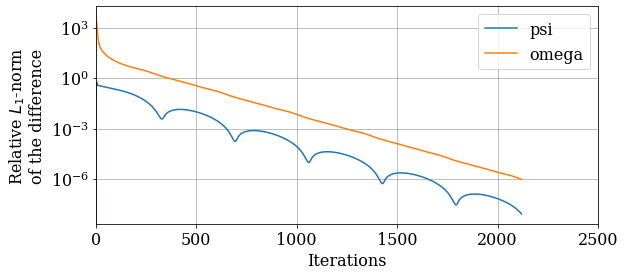

In [175]:
# Plot the convergence history for different methods.
pyplot.figure(figsize=(9.0, 4.0))
pyplot.xlabel('Iterations')
pyplot.ylabel('Relative $L_1$-norm\nof the difference')
pyplot.grid()
pyplot.semilogy(conv_psi2[:], label='psi')
pyplot.semilogy(conv_omega2[:], label='omega')
pyplot.legend()
pyplot.xlim(0, 2500);

In [176]:
ll2, mm2 = numpy.max(psi2), numpy.min(psi2)
print(ll2, mm2)

2.204823308999868e-06 -0.09984517027801075


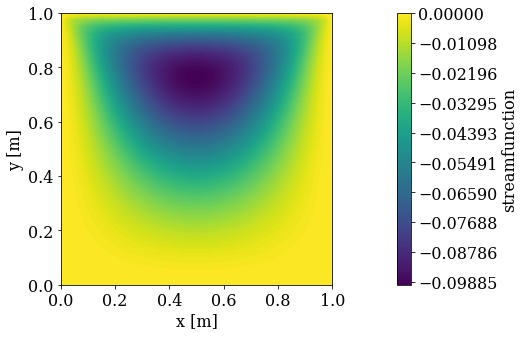

In [177]:
# Plot the filled contour of the streamfunction.
pyplot.figure(figsize=(8.0, 5.0))
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]')
levels = numpy.linspace(mm2, ll2, num=101)
contf = pyplot.contourf(x, y, psi2, levels=levels)
cbar = pyplot.colorbar(contf)
cbar.set_label('streamfunction')
pyplot.axis('scaled');

In [178]:
numpy.abs(omega2).max()

78.19266122699182

In [179]:
numpy.round(psi2[32,::8], 4)

array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

In the following function, I have also considered the effect of Reynolds number. The numerical method used is as per the first reference that I mentioned earlier. 

In [180]:
@jit(nopython=True)
def cavity_gauss_siedel_reynolds(psi0, omega0, dx, R, maxiter=20000, rtol = 1e-6):
    
    nx, ny = psi0.shape
    psi = psi0.copy()
    omega = omega0.copy()
    diff_psi = rtol + 1.0
    diff_omega = rtol + 1.0
    ite = 0
    conv_psi = []
    conv_omega = []
    
    while diff_omega>rtol or diff_psi>rtol and ite<maxiter:
        
        #Setting up the iterations
        psi_n = psi.copy()
        
        #iterating for psi
        for j in range(1, ny-1):
            for i in range(1, ny-1):
                psi[j, i] = 0.25*(psi[j-1, i] + psi[j+1, i] + psi[j, i-1] + psi[j, i+1] + omega[j, i]*(dx**2))
        
        diff_psi = numpy.sum(numpy.abs(psi - psi_n))
        
        #iterating for omega
        omega_n = omega.copy()
        
        #updating omega based on new boundary conditions with effect of Reynolds number
        for j in range(1, ny-1):
            for i in range(1, ny-1):
                omega[j, i] = 0.25*((1 + (R/4)*(psi[j+1, i] - psi[j-1, i]))*omega[j, i-1] + (1 + (R/4)*(psi[j, i+1] - psi[j, i-1]))*omega[j+1, i] + (1 - (R/4)*(psi[j+1, i] - psi[j-1, i]))*omega[j, i+1] + (1 - (R/4)*(psi[j, i+1] - psi[j, i-1]))*omega[j-1, i])
                            
        #Applying boundary conditions (second order accurate)
        #left bc
        for j in range(1, ny-1):
            #omega[j, 0] = (-2/(dx**2))*psi[j, 1]
            omega[j, 0] = (7.0*psi[j, 0] - 8.0*psi[j, 1] + psi[j, 2])/(2.0*dx**2)
        
        #bottom bc
        for i in range(1, nx-1):
            #omega[0, i] = (-2/(dx**2))*psi[1, i]
            omega[0, i] = (7.0*psi[0, i] - 8.0*psi[1, i] + psi[2, i])/(2.0*dx**2)
        
        #right bc
        for j in range(1, ny-1):
            #omega[j, -1] = (-2/(dx**2))*psi[j, -2]
            omega[j, -1] = (-7.0*psi[j, -1] - 8.0*psi[j, -2] + psi[j, -3])/(2.0*dx**2)
        
        #top bc
        for i in range(1, nx-1):
            #mega[-1, i] = 2/dx - (2/(dx**2))*psi[-2, i]
            omega[-1, i] = (7.0*psi[-1, i] - 8.0*psi[-2, i] + psi[-3, i])/(2.0*dx**2) - (3/dx)
        
        diff_omega = numpy.sum(numpy.abs(omega - omega_n))
        
        
        conv_psi.append(diff_psi)
        conv_omega.append(diff_omega)
        #print(conv_psi.size)
        
        ite = ite + 1
        
    return psi, omega, ite, conv_psi, conv_omega

In [181]:
tic = time.time()
R = 259.0
psi3, omega3, ites3, conv_psi3, conv_omega3 = cavity_gauss_siedel_reynolds(psi0, omega0, dx, R, maxiter=20000, rtol = 1e-6)
toc = time.time()

print('{} iterations '.format(ites3) + 'to reach a relative difference of {} for psi and {} for omega'.format(conv_psi3[-1], conv_omega3[-1]))
print('time required {}'.format(toc - tic))

2615 iterations to reach a relative difference of 1.3532020217305943e-08 for psi and 9.93655430544171e-07 for omega
time required 2.0410008430480957


#### Above function with Reynolds number is stable for R<260.0

In [182]:
ll3, mm3 = numpy.max(psi3), numpy.min(psi3)
print(ll, mm)

1.1537642791400761e-05 -0.1018065336169395


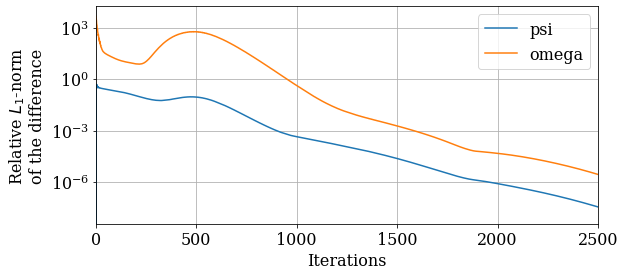

In [183]:
# Plot the convergence history
pyplot.figure(figsize=(9.0, 4.0))
pyplot.xlabel('Iterations')
pyplot.ylabel('Relative $L_1$-norm\nof the difference')
pyplot.grid()
pyplot.semilogy(conv_psi3[:], label='psi')
pyplot.semilogy(conv_omega3[:], label='omega')
pyplot.legend()
pyplot.xlim(0, 2500);

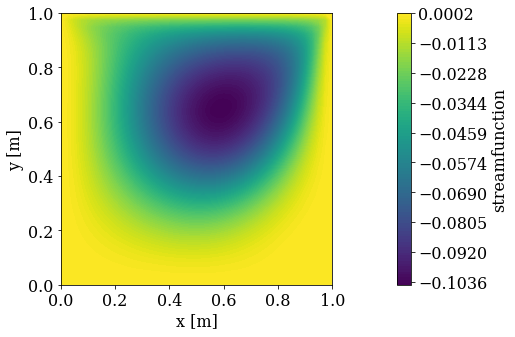

In [184]:
# Plot the filled contour of the streamfunction.
pyplot.figure(figsize=(8.0, 5.0))
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]')
levels = numpy.linspace(mm3, ll3, num=101)
contf = pyplot.contourf(x, y, psi3, levels=levels)
cbar = pyplot.colorbar(contf)
cbar.set_label('streamfunction')
pyplot.axis('scaled');